<a href="https://colab.research.google.com/github/nmningmei/Deep_learning_fMRI_EEG/blob/master/10_2_searchlight_RSA_word_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download data

In [1]:
!git clone https://github.com/nmningmei/METASEMA_encoding_model.git

Cloning into 'METASEMA_encoding_model'...
remote: Enumerating objects: 85, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 1705 (delta 23), reused 56 (delta 13), pack-reused 1620
Receiving objects: 100% (1705/1705), 409.13 MiB | 32.12 MiB/s, done.
Resolving deltas: 100% (516/516), done.
Checking out files: 100% (1161/1161), done.


# Import necessary python liraries

In [2]:
import os

from glob import glob

import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

from scipy.spatial import distance
from nibabel import load as load_fmri
from scipy.stats import spearmanr

try:
    from nilearn.input_data import NiftiMasker
    from nilearn.image import new_img_like
    from brainiak.searchlight.searchlight import Searchlight
    from brainiak.searchlight.searchlight import Ball
except:
    !pip install nilearn
    !python3 -m pip install -U brainiak
    from nilearn.input_data import NiftiMasker
    from nilearn.image import new_img_like
    from nilearn.image import resample_to_img
    from nilearn import plotting
    from nilearn.datasets import load_mni152_template
    from brainiak.searchlight.searchlight import Searchlight
    from brainiak.searchlight.searchlight import Ball

sns.set_context('poster')
sns.set_style('white')

     |████████████████████████████████| 3.1MB 4.4MB/s 
     |████████████████████████████████| 6.8MB 4.2MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.4MB 36.6MB/s 
     |████████████████████████████████| 6.2MB 40.4MB/s 
     |████████████████████████████████| 61kB 6.8MB/s 
  Using cached https://files.pythonhosted.org/packages/8d/43/7339dbabbc2793718d59703aace4166f53c29ee1c202f6ff5bf8a26c4d91/pybind11-2.6.2-py2.py3-none-any.whl
     |████████████████████████████████| 1.9MB 51.4MB/s 
  Created wheel for brainiak: filename=brainiak-0.11-cp37-cp37m-linux_x86_64.whl size=1102283 sha256=81b25640add01bbe294d644018b8804b1d36a1cae1f3e11ad516886868ea542d
  Stored in directory: /root/.cache/pip/wheels/9a/b1/79/ce43e78ff1ea8ed097c8b7c85b468d3209aefef55a8a6ef475
Successfully built brainiak
  Created wheel for mpi4py: filename=mpi

/usr/local/lib/python3.7/dist-packages/nilearn/datasets/__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load and inspect the data: BOLD signals and events

## concatenetate data from different sessions

In [3]:
condition = 'reenact'
data_dir = 'METASEMA_encoding_model/scripts/raw/'
bold_files = np.sort(glob(os.path.join(data_dir,'*','*.npy')))
csv_files = np.sort(glob(os.path.join(data_dir,'*','*.csv')))
example_func = os.path.join(data_dir,'example_func.nii.gz')
mask_img = os.path.join(data_dir,'mask.nii.gz')
word_model = os.path.join(data_dir,'word2vec.csv')
words = os.path.join(data_dir,'word.npy')

bold_data,csv_data = [],[]
# this is how we convert vectorized BOLD signals back to 3D volumes
masker = NiftiMasker(mask_img=mask_img,).fit(example_func)

for bold_file,csv_file in zip(bold_files,csv_files):
    temp_bold = np.load(bold_file)
    temp_csv = pd.read_csv(csv_file)

    bold_data.append(temp_bold)
    csv_data.append(temp_csv)
bold_data = np.concatenate(bold_data)
csv_data = pd.concat(csv_data)
_idx = csv_data['context'] == condition
bold_data = bold_data[_idx]
csv_data = csv_data.loc[_idx,:].reset_index()

whole_brain_data = masker.inverse_transform(bold_data)

word2vec = pd.read_csv(word_model)
words = np.load(words).astype(str)

In [4]:
csv_data

,index,chunks,context,targets,time_coords,time_indices,trials,words
0,0,1,reenact,animal,6.8000030517578125+7.650003433227539+8.5000038...,8+9+10+11+12+13,0,ARDILLA
1,1,1,reenact,animal,18.700008392333984+19.55000877380371+20.400009...,22+23+24+25+26+27,1,GALLINA
2,2,1,reenact,animal,30.600013732910156+31.450014114379883+32.30001...,36+37+38+39+40+41,2,GALLO
3,3,1,reenact,animal,42.50001907348633+43.350019454956055+44.200019...,50+51+52+53+54+55,3,CAMELLO
4,4,1,reenact,animal,54.4000244140625+55.25002479553223+56.10002517...,64+65+66+67+68+69,4,PERRO
...,...,...,...,...,...,...,...,...
247,31,9,reenact,animal,382.50017166137695+383.3501720428467+384.20017...,450+451+452+453+454+455,31,TIGRE
248,32,9,reenact,animal,395.25017738342285+396.1001777648926+396.95017...,465+466+467+468+469+470,32,OVEJA
249,33,9,reenact,animal,407.150182723999+408.00018310546875+408.850183...,479+480+481+482+483+484,33,CONEJO
250,34,9,reenact,tool,419.0501880645752+419.9001884460449+420.750188...,493+494+495+496+497+498,34,LLAVE


## Plot the word2vec model of the 36 unique words

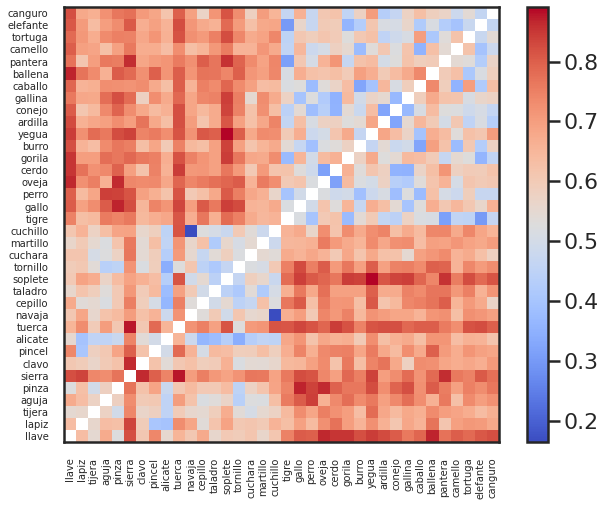

In [5]:
df_plot = word2vec[words]
corr = distance.squareform(distance.pdist(df_plot.values.T,'correlation'))
np.fill_diagonal(corr,np.nan)
fig,ax = plt.subplots(figsize = (10,8))
im = ax.imshow(corr,
               origin = 'lower',
               cmap = plt.cm.coolwarm,
               )
plt.colorbar(im)
ax.set(yticks = np.arange(36),xticks = np.arange(36))
_=ax.set_yticklabels(words,fontsize = 10,)
_=ax.set_xticklabels(words,fontsize = 10,rotation = 90)

## Helper functions

In [6]:
def normalize(data,axis = 1):
    return data - data.mean(axis).reshape(-1,1)
# Define voxel function
def sfn(l, msk, myrad, bcast_var):
    """
    l: BOLD
    msk: mask array
    myrad: not use
    bcast_var: word embedding model
    """
    BOLD = l[0][msk,:].T.copy() # vectorize the voxel values in the sphere
    #print(BOLD.shape) # <- for debugging
    model = bcast_var.copy() # vectorize the RDM
    #print(model.shape) # <- for debugging
    # pearson correlation
    RDM_X   = distance.pdist(normalize(BOLD),'correlation')
    RDM_y   = distance.pdist(normalize(model),'correlation')
    D,p     = spearmanr(RDM_X,RDM_y)
    return D

## Prepare the whole brain BOLD signals that are averaged from all the sessions

In [7]:
bold_average,word_average = [],[]
for _word, df_sub in csv_data.groupby(['words']):
    temp = bold_data[df_sub.index]
    bold_average.append(temp.mean(0))
    word_average.append(_word.lower())
bold_average = np.vstack(bold_average)
bold_average.shape

whole_brain_average = masker.inverse_transform(bold_average)
BOLD_image = np.asanyarray(whole_brain_average.dataobj)
print(BOLD_image.shape)

(88, 88, 66, 36)


# Searchlight RSA

## hyperparameters - not important

In [8]:
radius = 6 # in mm

### This is going to take some time to run - 1 fold - for the average of the BOLD signals

In [9]:
# Brainiak function
sl = Searchlight(sl_rad = radius, 
                max_blk_edge = radius - 1, 
                shape = Ball,
                min_active_voxels_proportion = 0,
                )
# distribute the data based on the sphere
## the first input is usually the BOLD signal, and it is in the form of 
## lists not arrays, representing each subject
## the second input is usually the mask, and it is in the form of array
sl.distribute([BOLD_image],np.asanyarray(load_fmri(mask_img).dataobj) == 1)
# broadcasted data is the data that remains the same during RSA
sl.broadcast(df_plot[word_average].values.T)
# run searchlight algorithm
global_outputs = sl.run_searchlight(sfn,
                                    pool_size = -1, # we run each RSA using a single CPU
                                    )

## Convert the numpy array to Nifti

In [10]:
correlations = new_img_like(example_func,np.asanyarray(global_outputs,dtype = np.float32))
# masking
correlations = masker.inverse_transform(masker.transform_single_imgs(correlations))

## Visualization

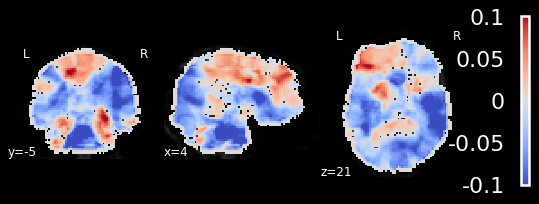

In [11]:
plotting.plot_stat_map(correlations,
                       example_func,
                       threshold = 1e-3,
                       draw_cross = False,
                       cmap = plt.cm.coolwarm,
                       vmax = .1,
                       )